In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Train-val split
data_dir = 'C:/Users/leong/Desktop/CSY3S2/CS3264/Project 2/isic2019_modified'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'

num_classes = 5  
batch_size = 32
num_epochs = 20
class_weights_tensor = torch.tensor([0.4637030299585015, 0.20220567335569326, 0.2313683133420499, 0.033141947586834176, 0.06958103575692115], dtype=torch.float).to(device)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6521, 0.5233, 0.5159], std=[0.2284, 0.2071, 0.2186])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6521, 0.5233, 0.5159], std=[0.2284, 0.2071, 0.2186])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4),
}


class ResNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(ResNetCustom, self).__init__()
        # Load pretrained ResNet-50
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.resnet = resnet50(weights=weights)

        # The feature count for the fully connected layer in ResNet-50 is 2048
        num_input_features = 2048

        # Replace the last fully connected layer with a new one
        self.resnet.fc = nn.Linear(num_input_features, num_classes)

    def forward(self, x):
        # Forward pass through ResNet backbone
        x = self.resnet(x)
        return x
    

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
model = ResNetCustom(num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

cuda


In [2]:
# Training loop
print("Start training")
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloaders["train"]) 
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

    # After each epoch, evaluate accuracy on the validation set
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

    epoch_acc = correct / total 
    val_epoch_loss = val_running_loss / len(dataloaders["val"])

    print(f'Validation Accuracy after epoch {epoch+1}: {epoch_acc:.4f}, Loss: {val_epoch_loss:.4f}')

    # Save the model if it has a better accuracy than the best model seen so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), 'resnet50sgd_best_with_norm_and_trans.pth')
        print('Model saved as rresnet50sgd_best_with_norm_and_trans.pth')

print('Finished Training')


Start training
Epoch 1, Loss: 0.6632
Validation Accuracy after epoch 1: 0.6451, Loss: 0.9597
Model saved as rresnet50sgd_best_with_norm_and_trans.pth
Epoch 2, Loss: 0.5321
Validation Accuracy after epoch 2: 0.7130, Loss: 0.7871
Model saved as rresnet50sgd_best_with_norm_and_trans.pth
Epoch 3, Loss: 0.4749
Validation Accuracy after epoch 3: 0.7241, Loss: 0.7388
Model saved as rresnet50sgd_best_with_norm_and_trans.pth
Epoch 4, Loss: 0.4117
Validation Accuracy after epoch 4: 0.7645, Loss: 0.6584
Model saved as rresnet50sgd_best_with_norm_and_trans.pth
Epoch 5, Loss: 0.3707
Validation Accuracy after epoch 5: 0.7554, Loss: 0.6707
Epoch 6, Loss: 0.3276
Validation Accuracy after epoch 6: 0.7753, Loss: 0.6103
Model saved as rresnet50sgd_best_with_norm_and_trans.pth
Epoch 7, Loss: 0.2937
Validation Accuracy after epoch 7: 0.7742, Loss: 0.6500
Epoch 8, Loss: 0.2598
Validation Accuracy after epoch 8: 0.7910, Loss: 0.6507
Model saved as rresnet50sgd_best_with_norm_and_trans.pth
Epoch 9, Loss: 0.23

Test Accuracy: 0.8179
Precision: 0.8138
Recall: 0.8179
F1 Score: 0.8089
MCC: 0.7298


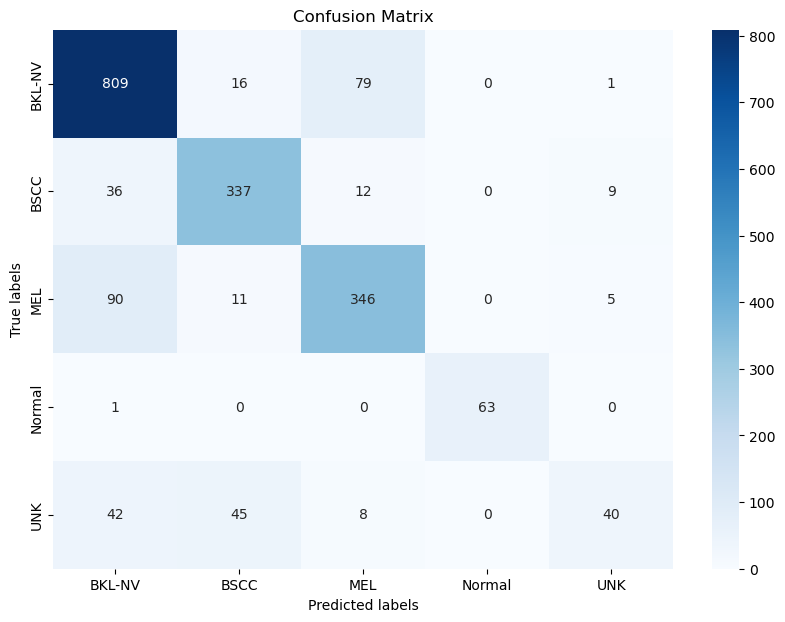

In [4]:
import numpy as np 
import torch 
import torchvision.transforms as transforms 
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix 
import seaborn as sns  # For a nicer confusion matrix plot 
test_transforms = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.6521, 0.5233, 0.5159], std=[0.2284, 0.2071, 0.2186]) 
]) 
 
test_dir = 'C:/Users/leong/Desktop/CSY3S2/CS3264/Project 2/isic2019_modified/test'  # specify the path to your test data 
image_datasets['test'] = datasets.ImageFolder(test_dir, test_transforms) 
 
dataloaders['test'] = torch.utils.data.DataLoader( 
    image_datasets['test'], 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4 
) 
 
# Load the model 
model = ResNetCustom(num_classes) 
model.load_state_dict(torch.load('resnet50sgd_best_with_norm_and_trans.pth', map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('best_model_with_norm_and_trans_big.pth')) 
model.to(device) 
model.eval()  # Set model to evaluation mode 
 
# Initialize the prediction and actual label lists 
test_predictions = [] 
test_actual = [] 
 
# Ensure the test loader is correctly set 
test_loader = dataloaders['test'] 
 
with torch.no_grad(): 
    for images, labels in test_loader: 
        images = images.to(device) 
        labels = labels.to(device) 
        outputs = model(images) 
         
        _, predicted = torch.max(outputs.data, 1) 
        test_predictions.extend(predicted.view(-1).cpu().numpy()) 
        test_actual.extend(labels.view(-1).cpu().numpy()) 
 
# Convert lists to numpy arrays 
test_predictions = np.array(test_predictions) 
test_actual = np.array(test_actual) 
 
# Calculate metrics 
test_accuracy = np.mean(test_predictions == test_actual) 
precision = precision_score(test_actual, test_predictions, average='weighted') 
recall = recall_score(test_actual, test_predictions, average='weighted') 
f1 = f1_score(test_actual, test_predictions, average='weighted')

mcc = matthews_corrcoef(test_actual, test_predictions)
 
print(f'Test Accuracy: {test_accuracy:.4f}') 
print(f'Precision: {precision:.4f}') 
print(f'Recall: {recall:.4f}') 
print(f'F1 Score: {f1:.4f}') 
print(f'MCC: {mcc:.4f}')

# Function to plot the confusion matrix 
def plot_confusion_matrix(cm, class_names): 
    plt.figure(figsize=(10, 7)) 
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names) 
    plt.xlabel('Predicted labels') 
    plt.ylabel('True labels') 
    plt.title('Confusion Matrix') 
    plt.show() 
 
# Compute and plot confusion matrix 
cm = confusion_matrix(test_actual, test_predictions) 
plot_confusion_matrix(cm, class_names=['BKL-NV', 'BSCC', 'MEL', 'Normal', 'UNK'])
